In [2]:
RUN_ON_KAGGLE = False
DEBUG = False

In [3]:
%%capture
if RUN_ON_KAGGLE:
    # installing offline dependencies
    !pip install -U /kaggle/input/faiss-gpu-173-python310/faiss_gpu-1.7.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl
    !cp -rf /kaggle/input/sentence-transformers-222/sentence-transformers /kaggle/working/sentence-transformers
    !pip install -U /kaggle/working/sentence-transformers
    !pip install -U /kaggle/input/blingfire-018/blingfire-0.1.8-py3-none-any.whl

    !pip install --no-index --no-deps /kaggle/input/llm-whls/transformers-4.31.0-py3-none-any.whl
    !pip install --no-index --no-deps /kaggle/input/llm-whls/peft-0.4.0-py3-none-any.whl
    !pip install --no-index --no-deps /kaggle/input/llm-whls/datasets-2.14.3-py3-none-any.whl
    !pip install --no-index --no-deps /kaggle/input/llm-whls/trl-0.5.0-py3-none-any.whl
    
    !pip install "/kaggle/input/blingfire-018/blingfire-0.1.8-py3-none-any.whl" --no-index
    !pip install "/kaggle/input/peft-native/peft-0.4.0-py3-none-any.whl" --no-index --find-links="/kaggle/input/peft-native/"
    !pip install "/kaggle/input/bitsandbytes-0410/bitsandbytes-0.41.0-py3-none-any.whl" --no-index
    !pip install "/kaggle/input/accelerate-native/accelerate-0.21.0-py3-none-any.whl" --no-index --find-links="/kaggle/input/accelerate-native/"
    !pip install "/kaggle/input/transformers-native/transformers-4.31.0-py3-none-any.whl" --no-index --find-links="/kaggle/input/transformers-native/"

In [4]:
import os, time
import gc
import pandas as pd
import numpy as np
import re
from tqdm.auto import tqdm
import blingfire as bf
# from __future__ import annotations

from collections.abc import Iterable

import faiss
from faiss import write_index, read_index

from sentence_transformers import SentenceTransformer

import torch
import ctypes
libc = ctypes.CDLL("libc.so.6")

from dataclasses import dataclass
from typing import Optional, Union

import torch
import numpy as np
import pandas as pd
from datasets import Dataset
from transformers import AutoTokenizer
from transformers import AutoModelForMultipleChoice, TrainingArguments, Trainer
from transformers.tokenization_utils_base import PreTrainedTokenizerBase, PaddingStrategy
from torch.utils.data import DataLoader

from scipy.special import softmax


===================================BUG REPORT===================================
Welcome to bitsandbytes. For bug reports, please submit your error trace to: https://github.com/TimDettmers/bitsandbytes/issues
CUDA_SETUP: WARNING! libcudart.so not found in any environmental path. Searching /usr/local/cuda/lib64...
CUDA SETUP: CUDA runtime path found: /usr/local/cuda/lib64/libcudart.so
CUDA SETUP: Highest compute capability among GPUs detected: 8.9
CUDA SETUP: Detected CUDA version 121
CUDA SETUP: Loading binary /home/viktor/miniconda3/envs/torch-env/lib/python3.9/site-packages/bitsandbytes/libbitsandbytes_cuda121.so...


/home/viktor/miniconda3/envs/torch-env/lib/python3.9/site-packages/bitsandbytes/cuda_setup/main.py:136: UserWarning: /home/viktor/miniconda3/envs/torch-env did not contain libcudart.so as expected! Searching further paths...
  warn(msg)
/home/viktor/miniconda3/envs/torch-env/lib/python3.9/site-packages/bitsandbytes/cuda_setup/main.py:136: UserWarning: WARNING: The following directories listed in your path were found to be non-existent: {PosixPath('vs/workbench/api/node/extensionHostProcess')}
  warn(msg)
/home/viktor/miniconda3/envs/torch-env/lib/python3.9/site-packages/bitsandbytes/cuda_setup/main.py:136: UserWarning: WARNING: The following directories listed in your path were found to be non-existent: {PosixPath('//matplotlib_inline.backend_inline'), PosixPath('module')}
  warn(msg)


In [5]:
if RUN_ON_KAGGLE:
    SIM_MODEL = '/kaggle/input/sentencetransformers-allminilml6v2/sentence-transformers_all-MiniLM-L6-v2'
else:
    SIM_MODEL = 'sentence-transformers/all-MiniLM-L6-v2'
DEVICE = 0
MAX_LENGTH = 384
BATCH_SIZE = 1


FILTER_LEN = 1 if DEBUG else 9
IND_SEARCH = 1 if DEBUG else 7
NUM_SENTENCES_INCLUDE = 1 if DEBUG else 25
CONTEXT_LEN = 1000 if DEBUG else 2305
CONTEXT_LEN_8BIT = 1000 if DEBUG else 2048
VAL_SIZE = 20 if DEBUG else 2000

if RUN_ON_KAGGLE:
    WIKI_PATH = "/kaggle/input/wikipedia-20230701"
else:
    WIKI_PATH = "/home/viktor/Documents/kaggle/kaggle_llm/data/kaggle-datasets/wikipedia-2023-07-faiss-index"
    
# file_for_local_cv = "/home/viktor/Documents/kaggle/kaggle_llm/data/kaggle-llm-science-exam/test.csv"    
file_for_local_cv = "/home/viktor/Documents/kaggle/kaggle_llm/data/data_dumps/more_questions/more_questions_raw_questions_wiki_sci_3_shuffled.csv"    

wiki_files = os.listdir(WIKI_PATH)

In [6]:
def process_documents(documents: Iterable[str],
                      document_ids: Iterable,
                      split_sentences: bool = True,
                      filter_len: int = FILTER_LEN,
                      disable_progress_bar: bool = False) -> pd.DataFrame:
    
    df = sectionize_documents(documents, document_ids, disable_progress_bar)

    if split_sentences:
        df = sentencize(df.text.values, 
                        df.document_id.values,
                        df.offset.values, 
                        filter_len, 
                        disable_progress_bar)
    return df


def sectionize_documents(documents: Iterable[str],
                         document_ids: Iterable,
                         disable_progress_bar: bool = False) -> pd.DataFrame:

    processed_documents = []
    for document_id, document in tqdm(zip(document_ids, documents), total=len(documents), disable=disable_progress_bar):
        row = {}
        text, start, end = (document, 0, len(document))
        row['document_id'] = document_id
        row['text'] = text
        row['offset'] = (start, end)

        processed_documents.append(row)

    _df = pd.DataFrame(processed_documents)
    if _df.shape[0] > 0:
        return _df.sort_values(['document_id', 'offset']).reset_index(drop=True)
    else:
        return _df


def sentencize(documents: Iterable[str],
               document_ids: Iterable,
               offsets: Iterable[tuple[int, int]],
               filter_len: int = FILTER_LEN,
               disable_progress_bar: bool = False) -> pd.DataFrame:

    document_sentences = []
    for document, document_id, offset in tqdm(zip(documents, document_ids, offsets), total=len(documents), disable=disable_progress_bar):
        try:
            _, sentence_offsets = bf.text_to_sentences_and_offsets(document)
            for o in sentence_offsets:
                if o[1]-o[0] > filter_len:
                    sentence = document[o[0]:o[1]]
                    abs_offsets = (o[0]+offset[0], o[1]+offset[0])
                    row = {}
                    row['document_id'] = document_id
                    row['text'] = sentence
                    row['offset'] = abs_offsets
                    document_sentences.append(row)
        except:
            continue
    return pd.DataFrame(document_sentences)

In [7]:
if RUN_ON_KAGGLE:
    trn = pd.read_csv("/kaggle/input/kaggle-llm-science-exam/test.csv").drop("id", axis=1)
else:
    trn = pd.read_csv(file_for_local_cv).drop("id", axis=1).sample(n=VAL_SIZE, random_state=42).reset_index(drop=True)
trn.head()

,Unnamed: 0,prompt,A,B,C,D,E,answer,cluster number,round
0,13884,What is the relationship between Adiantum and ...,Adiantum is a variant of AES,Adiantum is a cryptographic message authentica...,Adiantum uses AES for disk encryption,Adiantum is a low-powered mobile device runnin...,Adiantum uses a different construction for the...,C,590,0
1,20379,What is the cause of the painful bump in Osgoo...,Excessive bone growth at the tibial tuberosity,Fluid accumulation in the patellar ligament,Inflammation of the quadriceps muscle,Degeneration of the knee cartilage,Dislocation of the tibiofemoral joint,A,827,1
2,24313,What are the two most common types of tarsal c...,Calcaneo-cuboid and calcaneo-navicular,Talo-cuneiform and talo-tarsal,Navicular-cuboid and calcaneo-tarsal,Talo-calcaneal and talo-navicular,Calcaneo-navicular and talo-calcaneal,E,988,0
3,22258,What is the significance of dietary restrictio...,Dietary restrictions can worsen the symptoms o...,Dietary restrictions can completely cure ocula...,Dietary restrictions have no impact on the sym...,Dietary restrictions may reduce or eliminate t...,Dietary restrictions only impact the symptoms ...,D,902,0
4,16046,What is the purpose of isolating Parvibaculum ...,To remove it from wastewater treatment plants ...,To improve the aesthetics of activated sludge,To study its metabolic abilities and potential...,To increase the production of linear alkylbenz...,To enhance the growth of other bacteria in the...,C,668,0


In [8]:
model = SentenceTransformer(SIM_MODEL, device='cuda')
model.max_seq_length = MAX_LENGTH
model = model.half()

In [9]:
if RUN_ON_KAGGLE:
    sentence_index = read_index("/kaggle/input/wikipedia-2023-07-faiss-index/wikipedia_202307.index")
else:
    sentence_index = read_index("/home/viktor/Documents/kaggle/kaggle_llm/data/kaggle-datasets/wikipedia-2023-07-faiss-index/wikipedia_202307.index")

In [10]:
prompt_embeddings = model.encode(trn.prompt.values, batch_size=BATCH_SIZE, device=DEVICE, show_progress_bar=True, convert_to_tensor=True, normalize_embeddings=True)
prompt_embeddings = prompt_embeddings.detach().cpu().numpy()

Batches:   0%|          | 0/2000 [00:00<?, ?it/s]

In [11]:
## Get the top IND_SEARCH pages that are likely to contain the topic of interest
search_score, search_index = sentence_index.search(prompt_embeddings, IND_SEARCH)

In [12]:
## Save memory - delete sentence_index since it is no longer necessary
del sentence_index
del prompt_embeddings
_ = gc.collect()
libc.malloc_trim(0)

1

# Getting Sentences from the Relevant Titles

In [13]:
if RUN_ON_KAGGLE:
    df = pd.read_parquet("/kaggle/input/wikipedia-20230701/wiki_2023_index.parquet", columns=['id', 'file'])
else:
    df = pd.read_parquet("/home/viktor/Documents/kaggle/kaggle_llm/data/kaggle-datasets/wikipedia-2023-07-faiss-index/wiki_2023_index.parquet", columns=['id', 'file'])

In [14]:
## Get the article and associated file location using the index
wikipedia_file_data = []

for i, (scr, idx) in tqdm(enumerate(zip(search_score, search_index)), total=len(search_score)):
    scr_idx = idx
    _df = df.loc[scr_idx].copy()
    _df['prompt_id'] = i
    wikipedia_file_data.append(_df)
wikipedia_file_data = pd.concat(wikipedia_file_data).reset_index(drop=True)
wikipedia_file_data = wikipedia_file_data[['id', 'prompt_id', 'file']].drop_duplicates().sort_values(['file', 'id']).reset_index(drop=True)


del df
_ = gc.collect()
libc.malloc_trim(0)

  0%|          | 0/2000 [00:00<?, ?it/s]

1

In [15]:
## Get the full text data
wiki_text_data = []

for file in tqdm(wikipedia_file_data.file.unique(), total=len(wikipedia_file_data.file.unique())):
    _id = [str(i) for i in wikipedia_file_data[wikipedia_file_data['file']==file]['id'].tolist()]
    _df = pd.read_parquet(f"{WIKI_PATH}/{file}", columns=['id', 'text'])

    _df_temp = _df[_df['id'].isin(_id)].copy()
    del _df
    _ = gc.collect()
    libc.malloc_trim(0)
    wiki_text_data.append(_df_temp)
wiki_text_data = pd.concat(wiki_text_data).drop_duplicates().reset_index(drop=True)

_ = gc.collect()

  0%|          | 0/28 [00:00<?, ?it/s]

In [16]:
processed_wiki_text_data = process_documents(wiki_text_data.text.values, wiki_text_data.id.values)

  0%|          | 0/10920 [00:00<?, ?it/s]

  0%|          | 0/10920 [00:00<?, ?it/s]

In [ ]:

wiki_data_embeddings = model.encode(processed_wiki_text_data.text,
                                    batch_size=BATCH_SIZE,
                                    device=DEVICE,
                                    show_progress_bar=True,
                                    convert_to_tensor=True,
                                    normalize_embeddings=True)#.half()
wiki_data_embeddings = wiki_data_embeddings.detach().cpu().numpy()


In [ ]:
_ = gc.collect()

In [ ]:
trn['answer_all'] = trn.apply(lambda x: " ".join([x['A'], x['B'], x['C'], x['D'], x['E']]), axis=1)
trn['prompt_answer_stem'] = trn['prompt'] + " " + trn['answer_all']

In [ ]:
question_embeddings = model.encode(trn.prompt_answer_stem.values, batch_size=BATCH_SIZE, device=DEVICE, show_progress_bar=True, convert_to_tensor=True, normalize_embeddings=True)
question_embeddings = question_embeddings.detach().cpu().numpy()

# Extracting Matching Prompt-Sentence Pairs

In [ ]:
contexts = []

for r in tqdm(trn.itertuples(), total=len(trn)):

    prompt_id = r.Index

    prompt_indices = processed_wiki_text_data[processed_wiki_text_data['document_id'].isin(wikipedia_file_data[wikipedia_file_data['prompt_id']==prompt_id]['id'].values)].index.values

    if prompt_indices.shape[0] > 0:
        prompt_index = faiss.index_factory(wiki_data_embeddings.shape[1], "Flat")
        prompt_index.add(wiki_data_embeddings[prompt_indices])

        context = ""
        
        ## Get the top matches
        ss, ii = prompt_index.search(question_embeddings, NUM_SENTENCES_INCLUDE)
        for _s, _i in zip(ss[prompt_id], ii[prompt_id]):
            context += processed_wiki_text_data.loc[prompt_indices]['text'].iloc[_i] + " "
        
    contexts.append(context)
    


In [ ]:
trn['context'] = contexts

In [ ]:
if RUN_ON_KAGGLE or 'answer' not in trn.columns:
    trn[["prompt", "context", "A", "B", "C", "D", "E"]].to_csv("./test_context.csv", index=False)
else:
    trn[["prompt", "context", "A", "B", "C", "D", "E", "answer"]].to_csv("./test_context.csv", index=False)


# Inference

In [ ]:
test_df = pd.read_csv("test_context.csv")
test_df.index = list(range(len(test_df)))
test_df['id'] = list(range(len(test_df)))
# test_df["prompt"] = test_df["context"].apply(lambda x: x[:CONTEXT_LEN]) + " #### " +  test_df["prompt"]

In [ ]:
if RUN_ON_KAGGLE:
    model_dir = "/kaggle/input/llm-science-run-context-2"
else:
    model_dir = "/home/viktor/Documents/kaggle/kaggle_llm/data/kaggle-datasets/llm-science-run-context-2"
    
tokenizer = AutoTokenizer.from_pretrained(model_dir)
model = AutoModelForMultipleChoice.from_pretrained(model_dir).cuda()
model.eval()

DebertaV2ForMultipleChoice(
  (deberta): DebertaV2Model(
    (embeddings): DebertaV2Embeddings(
      (word_embeddings): Embedding(128100, 1024, padding_idx=0)
      (LayerNorm): LayerNorm((1024,), eps=1e-07, elementwise_affine=True)
      (dropout): StableDropout()
    )
    (encoder): DebertaV2Encoder(
      (layer): ModuleList(
        (0-23): 24 x DebertaV2Layer(
          (attention): DebertaV2Attention(
            (self): DisentangledSelfAttention(
              (query_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (key_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (value_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (pos_dropout): StableDropout()
              (dropout): StableDropout()
            )
            (output): DebertaV2SelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (LayerNorm): LayerNorm((1024,), eps=1e-07, elementwise_aff

In [ ]:

options = 'ABCDE'
indices = list(range(5))

option_to_index = {option: index for option, index in zip(options, indices)}
index_to_option = {index: option for option, index in zip(options, indices)}

def preprocess(example):
  
    
    first_sentence = [ "[CLS] " + example['context'] ] * 5
    second_sentences = [" #### " + example['prompt'] + " [SEP] " + example[option] + " [SEP]" for option in 'ABCDE']
    tokenized_example = tokenizer(first_sentence, 
                                    second_sentences, 
                                    truncation='only_first', 
                                    max_length=CONTEXT_LEN, 
                                    add_special_tokens=False)        
    if "answer" in example:
        tokenized_example["label"] = option_to_index[example["answer"]]
    
    return tokenized_example
            
    # first_sentence = [example['prompt']] * 5
    # second_sentence = []
    # for option in options:
    #     second_sentence.append(example[option])
    
    # tokenized_example = tokenizer(first_sentence, second_sentence, truncation='only_first')
    # tokenized_example['label'] = option_to_index[example['answer']]
    # return tokenized_example
    
def preprocess_for_8bit(example):
  
    
    first_sentence = [ "[CLS] " + example['context'] ] * 5
    second_sentences = [" #### " + example['prompt'] + " [SEP] " + example[option] + " [SEP]" for option in 'ABCDE']
    tokenized_example = tokenizer(first_sentence, 
                                    second_sentences, 
                                    truncation='only_first', 
                                    max_length=CONTEXT_LEN_8BIT, 
                                    add_special_tokens=False)        
    if "answer" in example:
        tokenized_example["label"] = option_to_index[example["answer"]]
    
    return tokenized_example
            
    # first_sentence = [example['prompt']] * 5
    # second_sentence = []
    # for option in options:
    #     second_sentence.append(example[option])
    
    # tokenized_example = tokenizer(first_sentence, second_sentence, truncation='only_first')
    # tokenized_example['label'] = option_to_index[example['answer']]
    # return tokenized_example

In [ ]:
@dataclass
class DataCollatorForMultipleChoice:
    tokenizer: PreTrainedTokenizerBase
    padding: Union[bool, str, PaddingStrategy] = True
    max_length: Optional[int] = None
    pad_to_multiple_of: Optional[int] = None
    
    def __call__(self, features):
        # label_name = "label" if 'label' in features[0].keys() else 'labels'
        # labels = [feature.pop(label_name) for feature in features]
        # batch_size = len(features)
        # num_choices = len(features[0]['input_ids'])
        # flattened_features = [
        #     [{k: v[i] for k, v in feature.items()} for i in range(num_choices)] for feature in features
        # ]
        # flattened_features = sum(flattened_features, [])
        
        # batch = self.tokenizer.pad(
        #     flattened_features,
        #     padding=self.padding,
        #     max_length=self.max_length,
        #     pad_to_multiple_of=self.pad_to_multiple_of,
        #     return_tensors='pt',
        # )
        # batch = {k: v.view(batch_size, num_choices, -1) for k, v in batch.items()}
        # batch['labels'] = torch.tensor(labels, dtype=torch.int64)
        # return batch
        
        batch_size = len(features)
        num_choices = len(features[0]["input_ids"])
        flattened_features = [
            [
                {k: v[i] for k, v in feature.items() if k not in ("context", "__index_level_0__", "label", "labels")}
                for i in range(num_choices)
            ] for feature in features
        ]
        flattened_features = sum(flattened_features, [])

        # _max_length = max([len(x["input_ids"]) for x in flattened_features])
        # print(f"{_max_length = }")

        batch = self.tokenizer.pad(
            flattened_features,
            padding=self.padding,
            max_length=self.max_length,
            pad_to_multiple_of=self.pad_to_multiple_of,
            return_tensors="pt",
        )
        batch = {k: v.view(batch_size, num_choices, -1) for k, v in batch.items()}
        if "label" in features[0].keys() or "labels" in features[0].keys():
            label_name = "label" if "label" in features[0].keys() else "labels"
            labels = [feature.pop(label_name) for feature in features]
            batch["labels"] = torch.tensor(labels, dtype=torch.int64)
        return batch
        
        

In [ ]:
if 'answer' in test_df.columns:
    tokenized_test_dataset = Dataset.from_pandas(test_df[['id', 'prompt', 'A', 'B', 'C', 'D', 'E', 'answer', 'context']].drop(columns=['id'])).map(preprocess, remove_columns=['prompt', 'A', 'B', 'C', 'D', 'E', 'answer', 'context'])
    tokenized_test_dataset = tokenized_test_dataset.remove_columns(["__index_level_0__"])
    data_collator = DataCollatorForMultipleChoice(tokenizer=tokenizer)
    test_dataloader = DataLoader(tokenized_test_dataset, batch_size=1, shuffle=False, collate_fn=data_collator)
else:
    tokenized_test_dataset = Dataset.from_pandas(test_df[['id', 'prompt', 'A', 'B', 'C', 'D', 'E', 'context']].drop(columns=['id'])).map(preprocess, remove_columns=['prompt', 'A', 'B', 'C', 'D', 'E', 'context'])
    tokenized_test_dataset = tokenized_test_dataset.remove_columns(["__index_level_0__"])
    data_collator = DataCollatorForMultipleChoice(tokenizer=tokenizer)
    test_dataloader = DataLoader(tokenized_test_dataset, batch_size=1, shuffle=False, collate_fn=data_collator)
    

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [ ]:
test_predictions = []

for batch in tqdm(test_dataloader):
    for k in batch.keys():
        batch[k] = batch[k].cuda()
    with torch.no_grad():
        outputs = model(**batch)
    test_predictions.append(outputs.logits.cpu().detach())
    
test_predictions = torch.cat(test_predictions)

In [ ]:
test_predictions = softmax(test_predictions, axis=1)
test_predictions[:10]

In [ ]:
ob_preds = test_predictions
del test_predictions

# viktor deberta 60k

In [ ]:
# model_dir = "/kaggle/input/how-to-train-open-book-model-part-1/model_v2"
if RUN_ON_KAGGLE:
    model_dir = "/kaggle/input/llm-submissions-viktor/work_dirs/deberta-v3-data-wiki_sci-with-wiki-sentence-context-eval-kaggle-all-folds-grad-accum-128-60k/deberta-v3-large-2023-09-05-07-35-55/checkpoint-3281"
else:
    model_dir = "/home/viktor/Documents/kaggle/kaggle_llm/work_dirs/deberta-v3-data-wiki_sci-with-wiki-sentence-context-eval-kaggle-all-folds-grad-accum-128-60k/deberta-v3-large-2023-09-05-07-35-55/checkpoint-3281"
    
tokenizer = AutoTokenizer.from_pretrained(model_dir)
model = AutoModelForMultipleChoice.from_pretrained(model_dir).cuda()
model.eval()

DebertaV2ForMultipleChoice(
  (deberta): DebertaV2Model(
    (embeddings): DebertaV2Embeddings(
      (word_embeddings): Embedding(128100, 1024, padding_idx=0)
      (LayerNorm): LayerNorm((1024,), eps=1e-07, elementwise_affine=True)
      (dropout): StableDropout()
    )
    (encoder): DebertaV2Encoder(
      (layer): ModuleList(
        (0-23): 24 x DebertaV2Layer(
          (attention): DebertaV2Attention(
            (self): DisentangledSelfAttention(
              (query_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (key_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (value_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (pos_dropout): StableDropout()
              (dropout): StableDropout()
            )
            (output): DebertaV2SelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (LayerNorm): LayerNorm((1024,), eps=1e-07, elementwise_aff

In [ ]:
test_predictions_viktor = []

for batch in tqdm(test_dataloader):
    for k in batch.keys():
        batch[k] = batch[k].cuda()
    with torch.no_grad():
        outputs = model(**batch)
    test_predictions_viktor.append(outputs.logits.cpu().detach())
    

test_predictions_viktor = torch.cat(test_predictions_viktor)


In [ ]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))
    
test_predictions_viktor_60k = sigmoid(test_predictions_viktor).numpy()
test_predictions_viktor_60k[:10]

In [ ]:
gc.collect()

# viktor deberta 160k

In [ ]:
# model_dir = "/kaggle/input/how-to-train-open-book-model-part-1/model_v2"
if RUN_ON_KAGGLE:
    model_dir = "/kaggle/input/llm-submissions-viktor/work_dirs/deberta-v3-data-wiki_sci-with-wiki-sentence-context-eval-kaggle-all-folds-grad-accum-128-60k/deberta-v3-large-2023-09-05-07-35-55/checkpoint-3281"
else:
    model_dir = "/home/viktor/Documents/kaggle/kaggle_llm/work_dirs/160k-viktor-and-deotte-dataset-deotte-preproc-deberta/deberta-v3-large-2023-09-17-10-00-20/checkpoint-14400"
    
tokenizer = AutoTokenizer.from_pretrained(model_dir)
model = AutoModelForMultipleChoice.from_pretrained(model_dir).cuda()
model.eval()

In [ ]:
test_predictions_viktor_160k = []

for batch in tqdm(test_dataloader):
    for k in batch.keys():
        batch[k] = batch[k].cuda()
    with torch.no_grad():
        outputs = model(**batch)
    test_predictions_viktor_160k.append(outputs.logits.cpu().detach())
    

test_predictions_viktor_160k = torch.cat(test_predictions_viktor_160k)


In [ ]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))
    
test_predictions_viktor_160k = sigmoid(test_predictions_viktor_160k).numpy()
test_predictions_viktor_160k[:10]

# viktor deberta 160k 8bit

In [ ]:
# model_dir = "/kaggle/input/how-to-train-open-book-model-part-1/model_v2"
if RUN_ON_KAGGLE:
    model_dir = "/kaggle/input/llm-submissions-viktor/work_dirs/deberta-v3-data-wiki_sci-with-wiki-sentence-context-eval-kaggle-all-folds-grad-accum-128-60k/deberta-v3-large-2023-09-05-07-35-55/checkpoint-3281"
else:
    model_dir = "/home/viktor/Documents/kaggle/kaggle_llm/work_dirs/160k-viktor-and-deotte-dataset-deotte-preproc-deberta/deberta-v3-large-2023-09-17-10-00-20/checkpoint-14400"
    
tokenizer = AutoTokenizer.from_pretrained(model_dir)
model = AutoModelForMultipleChoice.from_pretrained(model_dir, load_in_8bit=True)
model.eval()

DebertaV2ForMultipleChoice(
  (deberta): DebertaV2Model(
    (embeddings): DebertaV2Embeddings(
      (word_embeddings): Embedding(128100, 1024, padding_idx=0)
      (LayerNorm): LayerNorm((1024,), eps=1e-07, elementwise_affine=True)
      (dropout): StableDropout()
    )
    (encoder): DebertaV2Encoder(
      (layer): ModuleList(
        (0-23): 24 x DebertaV2Layer(
          (attention): DebertaV2Attention(
            (self): DisentangledSelfAttention(
              (query_proj): Linear8bitLt(in_features=1024, out_features=1024, bias=True)
              (key_proj): Linear8bitLt(in_features=1024, out_features=1024, bias=True)
              (value_proj): Linear8bitLt(in_features=1024, out_features=1024, bias=True)
              (pos_dropout): StableDropout()
              (dropout): StableDropout()
            )
            (output): DebertaV2SelfOutput(
              (dense): Linear8bitLt(in_features=1024, out_features=1024, bias=True)
              (LayerNorm): LayerNorm((1024,), ep

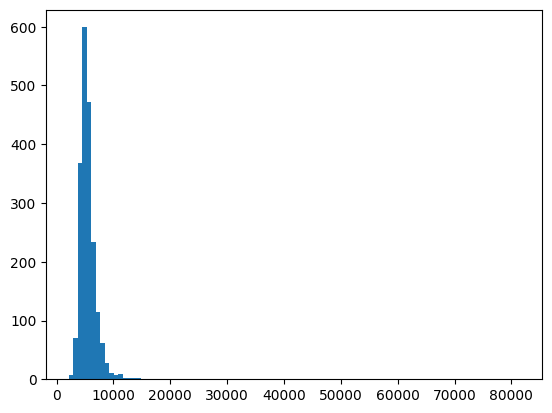

In [ ]:
test_df['context_len'] = test_df['context'].apply(lambda x: len(x))
import matplotlib.pyplot as plt

plt.hist(test_df['context_len'], bins=100);

In [22]:
if 'answer' in test_df.columns:
    tokenized_test_dataset = Dataset.from_pandas(test_df[['id', 'prompt', 'A', 'B', 'C', 'D', 'E', 'answer', 'context']].drop(columns=['id'])).map(preprocess_for_8bit, remove_columns=['prompt', 'A', 'B', 'C', 'D', 'E', 'answer', 'context'])
    tokenized_test_dataset = tokenized_test_dataset.remove_columns(["__index_level_0__"])
    data_collator = DataCollatorForMultipleChoice(tokenizer=tokenizer)
    test_dataloader = DataLoader(tokenized_test_dataset, batch_size=1, shuffle=False, collate_fn=data_collator)
else:
    tokenized_test_dataset = Dataset.from_pandas(test_df[['id', 'prompt', 'A', 'B', 'C', 'D', 'E', 'context']].drop(columns=['id'])).map(preprocess_for_8bit, remove_columns=['prompt', 'A', 'B', 'C', 'D', 'E', 'context'])
    tokenized_test_dataset = tokenized_test_dataset.remove_columns(["__index_level_0__"])
    data_collator = DataCollatorForMultipleChoice(tokenizer=tokenizer)
    test_dataloader = DataLoader(tokenized_test_dataset, batch_size=1, shuffle=False, collate_fn=data_collator)
    

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [23]:
test_predictions_viktor_160k_8bit = []

for batch in tqdm(test_dataloader):
    for k in batch.keys():
        batch[k] = batch[k].cuda()
    with torch.no_grad():
        outputs = model(**batch)
    test_predictions_viktor_160k_8bit.append(outputs.logits.cpu().detach())
    
    torch.cuda.empty_cache()

test_predictions_viktor_160k_8bit = torch.cat(test_predictions_viktor_160k_8bit)


  0%|          | 0/2000 [00:00<?, ?it/s]

You're using a DebertaV2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:7                                                                                    │
│                                                                                                  │
│    4 │   for k in batch.keys():                                                                  │
│    5 │   │   batch[k] = batch[k].cuda()                                                          │
│    6 │   with torch.no_grad():                                                                   │
│ ❱  7 │   │   outputs = model(**batch)                                                            │
│    8 │   test_predictions_viktor_160k_8bit.append(outputs.logits.cpu().detach())                 │
│    9 │                                                                                           │
│   10 │   torch.cuda.empty_cache()                                                                │
│                                                                                                  │
│ /home/viktor/miniconda3/envs/torch-env/lib/python3.9/site-packages/torch/nn/modules/module.py:15 │
│ 01 in _call_impl                                                                                 │
│                                                                                                  │
│   1498 │   │   if not (self._backward_hooks or self._backward_pre_hooks or self._forward_hooks   │
│   1499 │   │   │   │   or _global_backward_pre_hooks or _global_backward_hooks                   │
│   1500 │   │   │   │   or _global_forward_hooks or _global_forward_pre_hooks):                   │
│ ❱ 1501 │   │   │   return forward_call(*args, **kwargs)                                          │
│   1502 │   │   # Do not call functions when jit is used                                          │
│   1503 │   │   full_backward_hooks, non_full_backward_hooks = [], []                             │
│   1504 │   │   backward_pre_hooks = []                                                           │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
TypeError: forward() got an unexpected keyword argument 'input_ids'

In [ ]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))
    
test_predictions_viktor_160k_8bit = sigmoid(test_predictions_viktor_160k_8bit).numpy()
test_predictions_viktor_160k_8bit[:10]

# longformer (kaggle)

In [ ]:
if RUN_ON_KAGGLE:
    !cp /kaggle/input/datasets-wheel/datasets-2.14.4-py3-none-any.whl /kaggle/working
    !pip install  /kaggle/working/datasets-2.14.4-py3-none-any.whl
    !cp /kaggle/input/backup-806-viktor/util_openbook.py .

In [ ]:
import os
import gc
import pandas as pd
import numpy as np
import re
from tqdm.auto import tqdm
import blingfire as bf

from collections.abc import Iterable

import faiss
from faiss import write_index, read_index

from sentence_transformers import SentenceTransformer

import torch
import ctypes
libc = ctypes.CDLL("libc.so.6")

from dataclasses import dataclass
from typing import Optional, Union

import torch
import numpy as np
import pandas as pd
from datasets import Dataset
from transformers import AutoTokenizer
from transformers import AutoModelForMultipleChoice, TrainingArguments, Trainer
from transformers.tokenization_utils_base import PreTrainedTokenizerBase, PaddingStrategy
from torch.utils.data import DataLoader


def process_documents(documents: Iterable[str],
                      document_ids: Iterable,
                      split_sentences: bool = True,
                      filter_len: int = 3,
                      disable_progress_bar: bool = False) -> pd.DataFrame:
    """
    Main helper function to process documents from the EMR.

    :param documents: Iterable containing documents which are strings
    :param document_ids: Iterable containing document unique identifiers
    :param document_type: String denoting the document type to be processed
    :param document_sections: List of sections for a given document type to process
    :param split_sentences: Flag to determine whether to further split sections into sentences
    :param filter_len: Minimum character length of a sentence (otherwise filter out)
    :param disable_progress_bar: Flag to disable tqdm progress bar
    :return: Pandas DataFrame containing the columns `document_id`, `text`, `section`, `offset`
    """

    df = sectionize_documents(documents, document_ids, disable_progress_bar)

    if split_sentences:
        df = sentencize(df.text.values,
                        df.document_id.values,
                        df.offset.values,
                        filter_len,
                        disable_progress_bar)
    return df


def sectionize_documents(documents: Iterable[str],
                         document_ids: Iterable,
                         disable_progress_bar: bool = False) -> pd.DataFrame:
    """
    Obtains the sections of the imaging reports and returns only the
    selected sections (defaults to FINDINGS, IMPRESSION, and ADDENDUM).

    :param documents: Iterable containing documents which are strings
    :param document_ids: Iterable containing document unique identifiers
    :param disable_progress_bar: Flag to disable tqdm progress bar
    :return: Pandas DataFrame containing the columns `document_id`, `text`, `offset`
    """
    processed_documents = []
    for document_id, document in tqdm(zip(document_ids, documents), total=len(documents), disable=disable_progress_bar):
        row = {}
        text, start, end = (document, 0, len(document))
        row['document_id'] = document_id
        row['text'] = text
        row['offset'] = (start, end)

        processed_documents.append(row)

    _df = pd.DataFrame(processed_documents)
    if _df.shape[0] > 0:
        return _df.sort_values(['document_id', 'offset']).reset_index(drop=True)
    else:
        return _df


def sentencize(documents: Iterable[str],
               document_ids: Iterable,
               offsets: Iterable[tuple[int, int]],
               filter_len: int = 3,
               disable_progress_bar: bool = False) -> pd.DataFrame:
    """
    Split a document into sentences. Can be used with `sectionize_documents`
    to further split documents into more manageable pieces. Takes in offsets
    to ensure that after splitting, the sentences can be matched to the
    location in the original documents.

    :param documents: Iterable containing documents which are strings
    :param document_ids: Iterable containing document unique identifiers
    :param offsets: Iterable tuple of the start and end indices
    :param filter_len: Minimum character length of a sentence (otherwise filter out)
    :return: Pandas DataFrame containing the columns `document_id`, `text`, `section`, `offset`
    """

    document_sentences = []
    for document, document_id, offset in tqdm(zip(documents, document_ids, offsets), total=len(documents),
                                              disable=disable_progress_bar):
        try:
            _, sentence_offsets = bf.text_to_sentences_and_offsets(document)
            for o in sentence_offsets:
                if o[1] - o[0] > filter_len:
                    sentence = document[o[0]:o[1]]
                    abs_offsets = (o[0] + offset[0], o[1] + offset[0])
                    row = {}
                    row['document_id'] = document_id
                    row['text'] = sentence
                    row['offset'] = abs_offsets
                    document_sentences.append(row)
        except:
            continue
    return pd.DataFrame(document_sentences)


def get_contexts(RUN_ON_KAGGLE, VAL_SIZE, file_for_local_cv):
    if RUN_ON_KAGGLE:
        SIM_MODEL = '/kaggle/input/sentencetransformers-allminilml6v2/sentence-transformers_all-MiniLM-L6-v2'
    else:
        SIM_MODEL = 'sentence-transformers/all-MiniLM-L6-v2'
        
    DEVICE = 0
    MAX_LENGTH = 384
    BATCH_SIZE = 16

    if RUN_ON_KAGGLE:
        WIKI_PATH = "/kaggle/input/wikipedia-20230701"
    else:
        WIKI_PATH = "/home/viktor/Documents/kaggle/kaggle_llm/data/kaggle-datasets/wikipedia-2023-07-faiss-index"
    wiki_files = os.listdir(WIKI_PATH)


    if RUN_ON_KAGGLE:
        trn = pd.read_csv("/kaggle/input/kaggle-llm-science-exam/test.csv").drop("id", axis=1)
    else:
        trn = pd.read_csv(file_for_local_cv,index_col=0).sample(n=VAL_SIZE, random_state=42).reset_index(drop=True)

    model = SentenceTransformer(SIM_MODEL, device='cuda')
    model.max_seq_length = MAX_LENGTH
    model = model.half()

    if RUN_ON_KAGGLE:
        sentence_index = read_index("/kaggle/input/wikipedia-2023-07-faiss-index/wikipedia_202307.index")
    else:
        sentence_index = read_index("/home/viktor/Documents/kaggle/kaggle_llm/data/kaggle-datasets/wikipedia-2023-07-faiss-index/wikipedia_202307.index")

    # prompt_embeddings = model.encode(trn.prompt.values, batch_size=BATCH_SIZE, device=DEVICE, show_progress_bar=True, convert_to_tensor=True, normalize_embeddings=True)
    prompt_embeddings = model.encode(
        trn.apply(lambda row: f"{row['prompt']}\n{row['A']}\n{row['B']}\n{row['C']}\n{row['D']}\n{row['E']}",
                  axis=1).values,
        batch_size=BATCH_SIZE, device=DEVICE, show_progress_bar=True, convert_to_tensor=True, normalize_embeddings=True)

    prompt_embeddings = prompt_embeddings.detach().cpu().numpy()
    _ = gc.collect()

    # Get the top 20 pages that are likely to contain the topic of interest
    search_score, search_index = sentence_index.search(prompt_embeddings, 20)

    # Save memory - delete sentence_index since it is no longer necessary
    del sentence_index
    del prompt_embeddings
    _ = gc.collect()
    libc.malloc_trim(0)

    if RUN_ON_KAGGLE:
        df = pd.read_parquet("/kaggle/input/wikipedia-20230701/wiki_2023_index.parquet", columns=['id', 'file'])
    else:
        df = pd.read_parquet("/home/viktor/Documents/kaggle/kaggle_llm/data/kaggle-datasets/wikipedia-2023-07-faiss-index/wiki_2023_index.parquet", columns=['id', 'file'])

    # Get the article and associated file location using the index
    wikipedia_file_data = []

    for i, (scr, idx) in tqdm(enumerate(zip(search_score, search_index)), total=len(search_score)):
        scr_idx = idx
        _df = df.loc[scr_idx].copy()
        _df['prompt_id'] = i
        wikipedia_file_data.append(_df)
    wikipedia_file_data = pd.concat(wikipedia_file_data).reset_index(drop=True)
    wikipedia_file_data = wikipedia_file_data[['id', 'prompt_id', 'file']].drop_duplicates().sort_values(
        ['file', 'id']).reset_index(drop=True)

    # Save memory - delete df since it is no longer necessary
    del df
    _ = gc.collect()
    libc.malloc_trim(0)

    # Get the full text data
    wiki_text_data = []

    for file in tqdm(wikipedia_file_data.file.unique(), total=len(wikipedia_file_data.file.unique())):
        _id = [str(i) for i in wikipedia_file_data[wikipedia_file_data['file'] == file]['id'].tolist()]
        _df = pd.read_parquet(f"{WIKI_PATH}/{file}", columns=['id', 'text', 'title'])

        _df_temp = _df[_df['id'].isin(_id)].copy()
        del _df
        _ = gc.collect()
        libc.malloc_trim(0)
        wiki_text_data.append(_df_temp)
    wiki_text_data = pd.concat(wiki_text_data).drop_duplicates().reset_index(drop=True)
    _ = gc.collect()

    # Parse documents into sentences
    processed_wiki_text_data = process_documents(wiki_text_data.text.values, wiki_text_data.id.values)

    # Get embeddings of the wiki text data
    wiki_data_embeddings = model.encode(processed_wiki_text_data.text,
                                        batch_size=BATCH_SIZE,
                                        device=DEVICE,
                                        show_progress_bar=True,
                                        convert_to_tensor=True,
                                        normalize_embeddings=True)  # .half()
    wiki_data_embeddings = wiki_data_embeddings.detach().cpu().numpy()

    _ = gc.collect()

    # Combine all answers
    trn['answer_all'] = trn.apply(lambda x: " ".join([x['A'], x['B'], x['C'], x['D'], x['E']]), axis=1)

    # Search using the prompt and answers to guide the search
    trn['prompt_answer_stem'] = trn['prompt'] + " " + trn['answer_all']

    question_embeddings = model.encode(trn.prompt_answer_stem.values, batch_size=BATCH_SIZE, device=DEVICE,
                                       show_progress_bar=True, convert_to_tensor=True, normalize_embeddings=True)
    question_embeddings = question_embeddings.detach().cpu().numpy()

    # Parameter to determine how many relevant sentences to include
    NUM_SENTENCES_INCLUDE = 6

    # List containing just Context
    contexts = []

    for r in tqdm(trn.itertuples(), total=len(trn)):

        prompt_id = r.Index

        prompt_indices = processed_wiki_text_data[processed_wiki_text_data['document_id'].isin(
            wikipedia_file_data[wikipedia_file_data['prompt_id'] == prompt_id]['id'].values)].index.values

        if prompt_indices.shape[0] > 0:
            prompt_index = faiss.index_factory(wiki_data_embeddings.shape[1], "Flat")
            prompt_index.add(wiki_data_embeddings[prompt_indices])

            context = ""

            # Get the top matches
            ss, ii = prompt_index.search(question_embeddings, NUM_SENTENCES_INCLUDE)
            for _s, _i in zip(ss[prompt_id], ii[prompt_id]):
                context += processed_wiki_text_data.loc[prompt_indices]['text'].iloc[_i] + " "
        contexts.append(context)

    trn['context'] = contexts

    trn[["prompt", "context", "A", "B", "C", "D", "E"]].to_csv("./test_context.csv", index=False)


@dataclass
class DataCollatorForMultipleChoice:
    tokenizer: PreTrainedTokenizerBase
    padding: Union[bool, str, PaddingStrategy] = True
    max_length: Optional[int] = None
    pad_to_multiple_of: Optional[int] = None

    def __call__(self, features):
        label_name = "label" if 'label' in features[0].keys() else 'labels'
        labels = [feature.pop(label_name) for feature in features]
        batch_size = len(features)
        num_choices = len(features[0]['input_ids'])
        flattened_features = [
            [{k: v[i] for k, v in feature.items()} for i in range(num_choices)] for feature in features
        ]
        flattened_features = sum(flattened_features, [])

        batch = self.tokenizer.pad(
            flattened_features,
            padding=self.padding,
            max_length=self.max_length,
            pad_to_multiple_of=self.pad_to_multiple_of,
            return_tensors='pt',
        )
        batch = {k: v.view(batch_size, num_choices, -1) for k, v in batch.items()}
        batch['labels'] = torch.tensor(labels, dtype=torch.int64)
        return batch


def generate_openbook_output(RUN_ON_KAGGLE):
    test_df = pd.read_csv("test_context.csv")
    test_df.index = list(range(len(test_df)))
    test_df['id'] = list(range(len(test_df)))
    test_df["prompt"] = test_df["context"].apply(lambda x: x[:1750]) + " #### " + test_df["prompt"]
    test_df['answer'] = 'A'
    if RUN_ON_KAGGLE:
        model_dir = "/kaggle/input/llm-science-run-context-2"
    else:
        model_dir = "/home/viktor/Documents/kaggle/kaggle_llm/data/kaggle-datasets/llm-science-run-context-2"
    tokenizer = AutoTokenizer.from_pretrained(model_dir)
    model = AutoModelForMultipleChoice.from_pretrained(model_dir).cuda()
    model.eval()

    # We'll create a dictionary to convert option names (A, B, C, D, E) into indices and back again
    options = 'ABCDE'
    indices = list(range(5))

    option_to_index = {option: index for option, index in zip(options, indices)}
    index_to_option = {index: option for option, index in zip(options, indices)}

    def preprocess(example):
        # The AutoModelForMultipleChoice class expects a set of question/answer pairs
        # so we'll copy our question 5 times before tokenizing
        first_sentence = [example['prompt']] * 5
        second_sentence = []
        for option in options:
            second_sentence.append(example[option])
        # Our tokenizer will turn our text into token IDs BERT can understand
        tokenized_example = tokenizer(first_sentence, second_sentence, truncation=True)
        tokenized_example['label'] = option_to_index[example['answer']]
        return tokenized_example

    tokenized_test_dataset = Dataset.from_pandas(test_df[['id', 'prompt', 'A', 'B', 'C', 'D', 'E', 'answer']].drop(columns=['id'])).map(preprocess, remove_columns=['prompt', 'A', 'B', 'C', 'D', 'E', 'answer'])
    tokenized_test_dataset = tokenized_test_dataset.remove_columns(["__index_level_0__"])
    data_collator = DataCollatorForMultipleChoice(tokenizer=tokenizer)
    test_dataloader = DataLoader(tokenized_test_dataset, batch_size=1, shuffle=False, collate_fn=data_collator)

    test_predictions = []
    for batch in test_dataloader:
        for k in batch.keys():
            batch[k] = batch[k].cuda()
        with torch.no_grad():
            outputs = model(**batch)
        test_predictions.append(outputs.logits.cpu().detach())

    test_predictions = torch.cat(test_predictions)

    predictions_as_ids = np.argsort(-test_predictions, 1)

    predictions_as_answer_letters = np.array(list('ABCDE'))[predictions_as_ids]
    # predictions_as_answer_letters[:3]

    predictions_as_string = test_df['prediction'] = [
        ' '.join(row) for row in predictions_as_answer_letters[:, :3]
    ]

    submission = test_df[['id', 'prediction']]
    submission.to_csv('submission_backup.csv', index=False)


In [ ]:
import pickle

get_contexts(RUN_ON_KAGGLE, VAL_SIZE, file_for_local_cv)
generate_openbook_output(RUN_ON_KAGGLE)

import gc
gc.collect()

In [ ]:
import pandas as pd
backup_model_predictions = pd.read_csv("submission_backup.csv")

In [ ]:
if RUN_ON_KAGGLE:
    !cp -r /kaggle/input/stem-wiki-cohere-no-emb /kaggle/working
    !cp -r /kaggle/input/all-paraphs-parsed-expanded /kaggle/working/

In [ ]:
from datasets import load_dataset, load_from_disk

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
import unicodedata


def SplitList(mylist, chunk_size):
    return [mylist[offs:offs+chunk_size] for offs in range(0, len(mylist), chunk_size)]

def get_relevant_documents_parsed(df_valid):
    df_chunk_size=600
    if RUN_ON_KAGGLE:
        paraphs_parsed_dataset = load_from_disk("/kaggle/working/all-paraphs-parsed-expanded")
    else:
        paraphs_parsed_dataset = load_from_disk("/home/viktor/Documents/kaggle/kaggle_llm/data/kaggle-datasets/all-paraphs-parsed-expanded")
    
    modified_texts = paraphs_parsed_dataset.map(lambda example:
                                             {'temp_text':
                                              f"{example['title']} {example['section']} {example['text']}".replace('\n'," ").replace("'","")},
                                             num_proc=2)["temp_text"]
    
    all_articles_indices = []
    all_articles_values = []
    for idx in tqdm(range(0, df_valid.shape[0], df_chunk_size)):
        df_valid_ = df_valid.iloc[idx: idx+df_chunk_size]
    
        articles_indices, merged_top_scores = retrieval(df_valid_, modified_texts)
        all_articles_indices.append(articles_indices)
        all_articles_values.append(merged_top_scores)
        
    article_indices_array =  np.concatenate(all_articles_indices, axis=0)
    articles_values_array = np.concatenate(all_articles_values, axis=0).reshape(-1)
    
    top_per_query = article_indices_array.shape[1]
    articles_flatten = [(
                         articles_values_array[index],
                         paraphs_parsed_dataset[idx.item()]["title"],
                         paraphs_parsed_dataset[idx.item()]["text"],
                        )
                        for index,idx in enumerate(article_indices_array.reshape(-1))]
    retrieved_articles = SplitList(articles_flatten, top_per_query)
    return retrieved_articles



def get_relevant_documents(df_valid):
    df_chunk_size=800
    if RUN_ON_KAGGLE:
        cohere_dataset_filtered = load_from_disk("/kaggle/working/stem-wiki-cohere-no-emb")
    else:
        cohere_dataset_filtered = load_from_disk("/home/viktor/Documents/kaggle/kaggle_llm/data/kaggle-datasets/wiki-stem-cohere")
    modified_texts = cohere_dataset_filtered.map(lambda example:
                                             {'temp_text':
                                              unicodedata.normalize("NFKD", f"{example['title']} {example['text']}").replace('"',"")},
                                             num_proc=2)["temp_text"]
    
    all_articles_indices = []
    all_articles_values = []
    for idx in tqdm(range(0, df_valid.shape[0], df_chunk_size)):
        df_valid_ = df_valid.iloc[idx: idx+df_chunk_size]
    
        articles_indices, merged_top_scores = retrieval(df_valid_, modified_texts)
        all_articles_indices.append(articles_indices)
        all_articles_values.append(merged_top_scores)
        
    article_indices_array =  np.concatenate(all_articles_indices, axis=0)
    articles_values_array = np.concatenate(all_articles_values, axis=0).reshape(-1)
    
    top_per_query = article_indices_array.shape[1]
    articles_flatten = [(
                         articles_values_array[index],
                         cohere_dataset_filtered[idx.item()]["title"],
                         unicodedata.normalize("NFKD", cohere_dataset_filtered[idx.item()]["text"]),
                        )
                        for index,idx in enumerate(article_indices_array.reshape(-1))]
    retrieved_articles = SplitList(articles_flatten, top_per_query)
    return retrieved_articles



def retrieval(df_valid, modified_texts):
    
    corpus_df_valid = df_valid.apply(lambda row:
                                     f'{row["prompt"]}\n{row["prompt"]}\n{row["prompt"]}\n{row["A"]}\n{row["B"]}\n{row["C"]}\n{row["D"]}\n{row["E"]}',
                                     axis=1).values
    vectorizer1 = TfidfVectorizer(ngram_range=(1,2),
                                 token_pattern=r"(?u)\b[\w/.-]+\b|!|/|\?|\"|\'",
                                 stop_words=stop_words)
    vectorizer1.fit(corpus_df_valid)
    vocab_df_valid = vectorizer1.get_feature_names_out()
    vectorizer = TfidfVectorizer(ngram_range=(1,2),
                                 token_pattern=r"(?u)\b[\w/.-]+\b|!|/|\?|\"|\'",
                                 stop_words=stop_words,
                                 vocabulary=vocab_df_valid)
    vectorizer.fit(modified_texts[:500000])
    corpus_tf_idf = vectorizer.transform(corpus_df_valid)
    
    print(f"length of vectorizer vocab is {len(vectorizer.get_feature_names_out())}")

    chunk_size = 100000
    top_per_chunk = 10
    top_per_query = 10

    all_chunk_top_indices = []
    all_chunk_top_values = []

    for idx in tqdm(range(0, len(modified_texts), chunk_size)):
        wiki_vectors = vectorizer.transform(modified_texts[idx: idx+chunk_size])
        temp_scores = (corpus_tf_idf * wiki_vectors.T).toarray()
        chunk_top_indices = temp_scores.argpartition(-top_per_chunk, axis=1)[:, -top_per_chunk:]
        chunk_top_values = temp_scores[np.arange(temp_scores.shape[0])[:, np.newaxis], chunk_top_indices]

        all_chunk_top_indices.append(chunk_top_indices + idx)
        all_chunk_top_values.append(chunk_top_values)

    top_indices_array = np.concatenate(all_chunk_top_indices, axis=1)
    top_values_array = np.concatenate(all_chunk_top_values, axis=1)
    
    merged_top_scores = np.sort(top_values_array, axis=1)[:,-top_per_query:]
    merged_top_indices = top_values_array.argsort(axis=1)[:,-top_per_query:]
    articles_indices = top_indices_array[np.arange(top_indices_array.shape[0])[:, np.newaxis], merged_top_indices]
    
    return articles_indices, merged_top_scores


def prepare_answering_input(
        tokenizer, 
        question,  
        options,   
        context,   
        max_seq_length=4096,
    ):
    c_plus_q   = context + ' ' + tokenizer.bos_token + ' ' + question
    c_plus_q_4 = [c_plus_q] * len(options)
    tokenized_examples = tokenizer(
        c_plus_q_4, options,
        max_length=max_seq_length,
        padding="longest",
        truncation=False,
        return_tensors="pt",
    )
    input_ids = tokenized_examples['input_ids'].unsqueeze(0)
    attention_mask = tokenized_examples['attention_mask'].unsqueeze(0)
    example_encoded = {
        "input_ids": input_ids.to(model.device.index),
        "attention_mask": attention_mask.to(model.device.index),
    }
    return example_encoded

In [ ]:
stop_words = ['each', 'you', 'the', 'use', 'used',
                  'where', 'themselves', 'nor', "it's", 'how', "don't", 'just', 'your',
                  'about', 'himself', 'with', "weren't", 'hers', "wouldn't", 'more', 'its', 'were',
                  'his', 'their', 'then', 'been', 'myself', 're', 'not',
                  'ours', 'will', 'needn', 'which', 'here', 'hadn', 'it', 'our', 'there', 'than',
                  'most', "couldn't", 'both', 'some', 'for', 'up', 'couldn', "that'll",
                  "she's", 'over', 'this', 'now', 'until', 'these', 'few', 'haven',
                  'of', 'wouldn', 'into', 'too', 'to', 'very', 'shan', 'before', 'the', 'they',
                  'between', "doesn't", 'are', 'was', 'out', 'we', 'me',
                  'after', 'has', "isn't", 'have', 'such', 'should', 'yourselves', 'or', 'during', 'herself',
                  'doing', 'in', "shouldn't", "won't", 'when', 'do', 'through', 'she',
                  'having', 'him', "haven't", 'against', 'itself', 'that',
                  'did', 'theirs', 'can', 'those',
                  'own', 'so', 'and', 'who', "you've", 'yourself', 'her', 'he', 'only',
                  'what', 'ourselves', 'again', 'had', "you'd", 'is', 'other',
                  'why', 'while', 'from', 'them', 'if', 'above', 'does', 'whom',
                  'yours', 'but', 'being', "wasn't", 'be']

In [ ]:
if RUN_ON_KAGGLE:
    df_valid = pd.read_csv("/kaggle/input/kaggle-llm-science-exam/test.csv")
else:
    df_valid = pd.read_csv(file_for_local_cv).sample(n=VAL_SIZE, random_state=42).reset_index(drop=True)
retrieved_articles_parsed = get_relevant_documents_parsed(df_valid)
gc.collect()

In [ ]:
df_valid

In [ ]:
retrieved_articles = get_relevant_documents(df_valid)
gc.collect()

In [ ]:
# empty cuda cache
torch.cuda.empty_cache()
gc.collect()

In [ ]:
from transformers import LongformerTokenizer, LongformerForMultipleChoice

if RUN_ON_KAGGLE:
    tokenizer = LongformerTokenizer.from_pretrained("/kaggle/input/longformer-race-model/longformer_qa_model")
    model = LongformerForMultipleChoice.from_pretrained("/kaggle/input/longformer-race-model/longformer_qa_model").cuda()
else:
    tokenizer = LongformerTokenizer.from_pretrained("/home/viktor/Documents/kaggle/kaggle_llm/data/kaggle-datasets/longformer-race-model/longformer_qa_model")
    model = LongformerForMultipleChoice.from_pretrained("/home/viktor/Documents/kaggle/kaggle_llm/data/kaggle-datasets/longformer-race-model/longformer_qa_model").cuda()
    

In [ ]:
predictions = []

test_predictions_longformer_1 = []
test_predictions_longformer_2 = []
longformer_contexts = []


for index in tqdm(range(df_valid.shape[0])):
    row = df_valid.iloc[index]
    # question is 'prompt'
    question = row['prompt']
    options = [row['A'], row['B'], row['C'], row['D'], row['E']]
    context1 = f"{retrieved_articles[index][-4][2]}\n{retrieved_articles[index][-3][2]}\n{retrieved_articles[index][-2][2]}\n{retrieved_articles[index][-1][2]}"
    context2 = f"{retrieved_articles_parsed[index][-3][2]}\n{retrieved_articles_parsed[index][-2][2]}\n{retrieved_articles_parsed[index][-1][2]}"
    
    longformer_contexts.append(context1)
    
    inputs1 = prepare_answering_input(
        tokenizer=tokenizer, question=question,
        options=options, context=context1,
        )
    inputs2 = prepare_answering_input(
        tokenizer=tokenizer, question=question,
        options=options, context=context2,
        )
    
    with torch.no_grad():
        outputs1 = model(**inputs1)    
        losses1 = -outputs1.logits[0].detach().cpu().numpy()
        probability1 = torch.softmax(torch.tensor(-losses1), dim=-1)
        
    with torch.no_grad():
        outputs2 = model(**inputs2)
        losses2 = -outputs2.logits[0].detach().cpu().numpy()
        probability2 = torch.softmax(torch.tensor(-losses2), dim=-1)
        
    
    test_predictions_longformer_1.append(probability1.numpy().astype(np.float16))
    test_predictions_longformer_2.append(probability2.numpy().astype(np.float16))
    


In [ ]:
test_predictions_longformer_1 = np.stack(test_predictions_longformer_1)
test_predictions_longformer_2 = np.stack(test_predictions_longformer_2)

In [ ]:
test_predictions_longformer_1.shape, test_predictions_longformer_1[:10]

# viktor 8bit with longformer context

In [ ]:
# model_dir = "/kaggle/input/how-to-train-open-book-model-part-1/model_v2"
if RUN_ON_KAGGLE:
    model_dir = "/kaggle/input/llm-submissions-viktor/work_dirs/deberta-v3-data-wiki_sci-with-wiki-sentence-context-eval-kaggle-all-folds-grad-accum-128-60k/deberta-v3-large-2023-09-05-07-35-55/checkpoint-3281"
else:
    model_dir = "/home/viktor/Documents/kaggle/kaggle_llm/work_dirs/160k-viktor-and-deotte-dataset-deotte-preproc-deberta/deberta-v3-large-2023-09-17-10-00-20/checkpoint-14400"
    
tokenizer = AutoTokenizer.from_pretrained(model_dir)
model = AutoModelForMultipleChoice.from_pretrained(model_dir, load_in_8bit=True)
model.eval()

In [ ]:
test_df['context'] = longformer_contexts
test_df['context_len'] = test_df['context'].apply(lambda x: len(x))
import matplotlib.pyplot as plt

plt.hist(test_df['context_len'], bins=100);

In [ ]:
if 'answer' in test_df.columns:
    tokenized_test_dataset = Dataset.from_pandas(test_df[['id', 'prompt', 'A', 'B', 'C', 'D', 'E', 'answer', 'context']].drop(columns=['id'])).map(preprocess_for_8bit, remove_columns=['prompt', 'A', 'B', 'C', 'D', 'E', 'answer', 'context'])
    tokenized_test_dataset = tokenized_test_dataset.remove_columns(["__index_level_0__"])
    data_collator = DataCollatorForMultipleChoice(tokenizer=tokenizer)
    test_dataloader = DataLoader(tokenized_test_dataset, batch_size=1, shuffle=False, collate_fn=data_collator)
else:
    tokenized_test_dataset = Dataset.from_pandas(test_df[['id', 'prompt', 'A', 'B', 'C', 'D', 'E', 'context']].drop(columns=['id'])).map(preprocess_for_8bit, remove_columns=['prompt', 'A', 'B', 'C', 'D', 'E', 'context'])
    tokenized_test_dataset = tokenized_test_dataset.remove_columns(["__index_level_0__"])
    data_collator = DataCollatorForMultipleChoice(tokenizer=tokenizer)
    test_dataloader = DataLoader(tokenized_test_dataset, batch_size=1, shuffle=False, collate_fn=data_collator)
    

In [ ]:
test_predictions_viktor_160k_8bit_lf_context = []

for batch in tqdm(test_dataloader):
    for k in batch.keys():
        batch[k] = batch[k].cuda()
    with torch.no_grad():
        outputs = model(**batch)
    test_predictions_viktor_160k_8bit_lf_context.append(outputs.logits.cpu().detach())
    

test_predictions_viktor_160k_8bit_lf_context = torch.cat(test_predictions_viktor_160k_8bit_lf_context)


In [ ]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))
    
test_predictions_viktor_160k_8bit_lf_context = sigmoid(test_predictions_viktor_160k_8bit_lf_context).numpy()
test_predictions_viktor_160k_8bit_lf_context[:10]

# checkpoint-5975-09025

In [ ]:
# model_dir = "/kaggle/input/how-to-train-open-book-model-part-1/model_v2"
if RUN_ON_KAGGLE:
    model_dir = "/kaggle/input/checkpoint-5975-09025"
else:
    model_dir = "/home/viktor/Documents/kaggle/kaggle_llm/data/kaggle-datasets/checkpoint-5975-09025"
tokenizer = AutoTokenizer.from_pretrained(model_dir)
model = AutoModelForMultipleChoice.from_pretrained(model_dir).cuda()
model.eval()

In [ ]:
test_predictionsc = []

for batch in tqdm(test_dataloader):
    for k in batch.keys():
        batch[k] = batch[k].cuda()
    with torch.no_grad():
        outputs = model(**batch)
    test_predictionsc.append(outputs.logits.cpu().detach())


test_predictionsc = torch.cat(test_predictionsc)

In [ ]:
test_predictionsc = softmax(test_predictionsc, axis=1)
test_predictionsc[:10]

In [ ]:
gc.collect()

In [ ]:
if RUN_ON_KAGGLE:
    model_dir = "/kaggle/input/using-deepspeed-with-hf-trainer/checkpoints_1"
else:
    model_dir = "/home/viktor/Documents/kaggle/kaggle_llm/data/kaggle-datasets/using-deepspeed-with-hf-trainer/checkpoints_1"
tokenizer = AutoTokenizer.from_pretrained(model_dir)
model = AutoModelForMultipleChoice.from_pretrained(model_dir).cuda()
model.eval()

In [ ]:
test_predictionsi = []

for batch in tqdm(test_dataloader):
    for k in batch.keys():
        batch[k] = batch[k].cuda()
    with torch.no_grad():
        outputs = model(**batch)
    test_predictionsi.append(outputs.logits.cpu().detach())
    
test_predictionsi = torch.cat(test_predictionsi)

In [ ]:
test_predictionsi = softmax(test_predictionsi, axis=1)
test_predictionsi[:10]

In [ ]:
gc.collect()

# combine predictions (and find best combination on local CV )

In [ ]:
preds_dict = {
    'chris': test_predictionsc,
    'openbook': ob_preds, 
    'itk_ob': test_predictionsi,   
    'viktor_60k': test_predictions_viktor_60k,
    'test_predictions_viktor_160k': test_predictions_viktor_160k,
    'test_predictions_viktor_160k_8bit': test_predictions_viktor_160k_8bit,
    'test_predictions_longformer_1': test_predictions_longformer_1,
    'test_predictions_longformer_2': test_predictions_longformer_2,
    'test_predictions_viktor_160k_8bit_lf_context':test_predictions_viktor_160k_8bit_lf_context,
}
# save preds_dict as pickle
with open('preds_dict.pickle', 'wb') as handle:
    pickle.dump(preds_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)


weights = np.ones(len(preds_dict))

predictions_overall = np.sum([preds_val*weight for preds_val, weight in zip(preds_dict.values(), weights)], axis=0)
predictions_overall = np.argsort(-predictions_overall)[:,:3]
predictions_as_answer_letters = np.array(list('ABCDE'))[predictions_overall]
test_df['prediction'] = [' '.join(pred) for pred in predictions_as_answer_letters]

def compute_map3(preds, actuals):
    correct_answers = [0, 0, 0]
    for pred, actual in zip(preds, actuals):
        if pred[0] == actual:
            correct_answers[0] += 1
        if pred[1] == actual:
            correct_answers[1] += 1./2
        if pred[2] == actual:
            correct_answers[2] += 1./3
    
    n_total = len(actuals)
    map3 = np.sum(correct_answers) / n_total
    
    return map3

if not RUN_ON_KAGGLE and 'answer' in test_df.columns:
    val_df = pd.read_csv(file_for_local_cv,index_col=0).sample(n=VAL_SIZE, random_state=42).reset_index(drop=True)
    
    val_df['A'] = val_df['A'].map(str)
    val_df['B'] = val_df['B'].map(str)
    val_df['C'] = val_df['C'].map(str)
    val_df['D'] = val_df['D'].map(str)
    val_df['E'] = val_df['E'].map(str)
    val_df['answer'] = val_df['answer'].map(str)

    val_df = val_df.reset_index(drop=True)
    
    # best_map3_score = 0
    # for i in tqdm(range(10000)):
    #     weights = np.random.uniform(0, 1, len(preds_dict))
    #     predictions_overall = np.sum([preds_val*weight for preds_val in zip(preds_dict.values(), weights)], axis=0)
    #     predictions_overall = np.argsort(-predictions_overall)[:,:3]
    #     predictions_as_answer_letters = np.array(list('ABCDE'))[predictions_overall]


    
    #     map3_score = compute_map3(predictions_as_answer_letters, val_df['answer'].values)
    
    #     if map3_score > best_map3_score:
    #         best_map3_score = map3_score
    #         print(weights)
    #         print(map3_score)
    
    # print(map3_score)
    
    

Experiments:

- all models: 0.8

In [ ]:
submission = df_valid[['id', 'prediction']]
submission.to_csv('submission.csv', index=False)

pd.read_csv('submission.csv').head(10)